# Automatic Differentiation and Backpropagation

### Resources
* [UBC autodiff lecture](https://www.cs.ubc.ca/~fwood/CS340/lectures/AD1.pdf)
* [U of T autodiff slides](https://www.cs.toronto.edu/~rgrosse/courses/csc321_2018/slides/lec10.pdf)
* [Leimao Blog post](https://leimao.github.io/article/Automatic-Differentiation/)
* [Ari Seff video](https://www.youtube.com/watch?v=wG_nF1awSSY)
* [UMass autodiff](https://people.cs.umass.edu/~domke/courses/sml2011/08autodiff_nnets.pdf)
* [CS231n Backprop](https://cs231n.github.io/optimization-2/)
* [Autodiff In Machine Learning: A Survey](https://arxiv.org/abs/1502.05767)
* [CS229 Backprop](http://cs229.stanford.edu/notes2020spring/cs229-notes-deep_learning.pdf)
* [Computation Graph](http://alexminnaar.com/2018/07/14/simple-computational-graph-engine.html)

### Backpropagation and Autodiff

One of the core aspects of all modern deep learning frameworks is the idea of differential programming, which is
a paradigm that emphasizes being able to differentiate numeric programs using *automatic differentiation* 
(autodiff). This allows us to perform things like gradient-based optimization to fit the parameters of a neural
network efficiently and easily.

**Comparison of Differentiation Techniques**

Like we learned in high school, there are two ways that we can differentiate a given function. The first is 
*numeric differentiation* where we use finite differences to approximate the value of the derivative at a certain
value. The issue with this method is that it produces innacurate estimates as well as being very slow O(n) (need
to compute this for each individual weight). Using very small values for $h$ can also lead
to numerical stability problems.

\begin{equation}
    f^\prime(x) = \frac{f(x+h) - f(x)}{h}
\end{equation}

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Numeric differentiation
def numeric_diff(func, x, epsilon=0.0001):
    return (func(x+epsilon) - func(x)) / epsilon

def exponential_func(x):
    return np.exp(2*x) - x**3

numeric_diff(exponential_func, 3)

779.9373781153918

We can also use our derivative rules to perform *symbolic differentiation*. This gives us an exact expression for
the value of the derivative, however it can be slow and produce unneeded complexity in the resulting computation
(this is called expression swell where the derivative of a function can become exponentially larger such as when 
applying the product rule). This problem is exacerbated in the context of neural networks where the derivative is
computed w.r.t to many layers, making the expressions explode. The closed form solution it gives also is not
advantageous as we are only concerned with obtaining a numerical value.

\begin{align}
    f(x) &= e^{2x} - x^3\\
    f^\prime(x) &= 2e^{2x}-3x^2
\end{align}

779.8575869854702


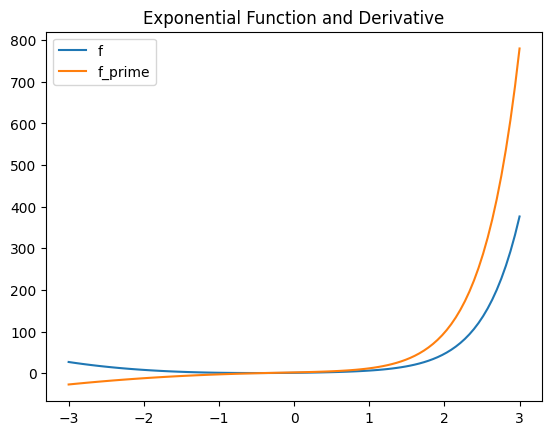

In [5]:
# Symbolic differentiation
def dx_exponential(x):
    return 2*np.exp(2*x) - 3*x**2

print(dx_exponential(3))

x = np.linspace(-3, 3, 100)
plt.plot(x, exponential_func(x), label='f')
plt.plot(x, dx_exponential(x), label='f_prime')
plt.title('Exponential Function and Derivative')
plt.legend()

## Autodiff and Why

All these problems are fixed by using autodiff. Unlike symbolic differentiation which tries to find an expression
for the function, autodiff just finds a numerical value. It uses the idea that a numeric program consists of a
combination of some primitive operations which we know the derivative of. For the most part the elementary functions
and operations like:
* Binary arithmetic operations
* Unary sign switches
* Transcendental functions (log, exp, trig)

<img src='./img/autodiff_ex.png' width='400'> </img>

You can think of autodiff as a way of reinterpreting a program by augmenting the arithmetic computation with the
computations of the derivatives.

### Evaluation Trace
We need to trace expressions for their primitive operations, and we can do this by breaking up an expression using
a [Wengert List](https://www.cs.cmu.edu/~wcohen/10-605/assignments/2016-fall/drafts/autodiff.pdf). There are in
general three categories of variables we need to consider in every expression for some function $f: R^n \to R^m$:
1. Input variables - $x_i$, for $i = 1, \dots n$
2. Intermediate variables - $v_i$ for $i = 1, \dots l$
3. Output variables - $y_{m-i}$, $i=m-1, \dots 0$

There are two main forms of autodiff, the first is forward mode and the second is reverse mode.

For example, $f(x_1, x_2) = \ln(x_1) + x_1x_2 - \sin(x_2)$ converted to an evaluation trace would be:
* $v_1 = \ln(x_1)$
* $v_2 = x_1 x_2$
* $v_3 = \sin(x_2)$
* $v_4 = v_1 + v2$
* $y = v_4 - v_3$


### Forward-mode Autodiff
Suppose we constructed the evaluation trace the same as above. We introduce new variables that are associated with
the intermediate variables $v_i$, $\dot{v_i}$ which are the derivatives. For example to determine the partial 
derivative of $x_1$ w.r.t $y$, we would use intermediate variables $\dot{v_i} = \frac{\partial v_i}{\partial x_1}$
and likewise for $x_2$. We call the collection of all these derviative variables the "tangent trace".

Then it is easy to see how we can perform the computation of the in the same evaluation pass as our evaluation 
trace. Suppose $x_1 = 2, x_2 = 5$. The tangent trace would be:
* $\dot{x_1} = 1$, $\dot{x_2} = 0$, remember it is the derivative w.r.t $x_1$. We substitute these into the rest 
of the equations.
* $\dot{v_1} = \frac{\partial v_1 = \partial \ln{x_1}}{\partial x_1} = \frac{1}{v_1 }\frac{\partial x_1}{\partial x_1} = \frac{\dot{x_1}}{v_1} $ --> notice how the necessary use of the chain rule nicely introduces our previous $\dot{x_1}$. We can compute this right after we compute $v_1$.
* $\dot{v_2} = \frac{\partial \dot{v_2} = \partial x_1 x_2}{\partial x_1}$, know we use product rule between
$x_1$ and $x_2$, so we sub in the corresponding $\dot{x_i} \implies \dot{v_2} = \dot{x_1}x_2 + x_1 \dot{x_2}$
* $\dot{v_3} = \frac{\partial v_3 = \partial \sin(x_2)}{\partial x_1} = \cos(x_2) \dot{x_2}$
* $\dot{v_4} = \frac{\partial v_4 = \partial v_1 + v_2}{\partial x_1} = \dot{v_2} + \dot{v_1}$ --> another example how previous work efficiently allows us to compute the intermediate derivatives
* $\dot{v_5} = \frac{\partial v_5 = \partial v_4 - v_5}{\partial x_1} = \dot{v_4} - \dot{v_5}$.

This gives us a single column of the the jacobian $\mathbf{J}_f$, or simply the gradient matrix $\nabla f$. We can
obtain the full Jacobian by performing a tangent trace on all other input variables (just $x_2$ in this case).

We can see that in forward mode autodiff, the runtime is remains in the same complexity class, with the constant 
overhead of having to compute the tangent trace. If we want the full Jacobian, the process would scale linearly
$\mathcal{O}(n)$ w.r.t to the number of input variables $n$. So we want to use forward mode auto diff if the number
of output variables $m >> n$, especially functions $f: \mathbb{R} \to \mathbb{R^m}$.

### Reverse-mode Autodiff
Reverse-mode autodiff is a generalized version of the backpropagation algorithm and in contrast to forward mode
autodiff it propagates the gradients backwards starting from the outputs.

We do this by performing a forward trace, keeping track of the intermediate values and the dependencies, then
starting from the outputs, we iteratively compute $\bar{v_i} = \frac{\partial y_j}{\partial v_i}$, which measures the
sensitivity of the output when $v_i$ is perturbed. Backpropagation is the case where we have a single scalar
output $y_j$.

### Chain Rule From a Distance
Suppose we have some arbitrarily nested function of some variable, which we will call $y = f^i(\theta)$, where $f^i$
represents $i$ functions being consecutively on $\theta$. Then the chain rule simply tells us that $\frac{\partial y}{\partial \theta} = \frac{\partial f^{i}(\theta)}{\partial f^{i-1}(\theta)} \frac{\partial f^{i-1}(\theta)}{\partial \theta} = \frac{\partial f^{i}(\theta)}{\partial f^{i-1}(\theta)} \frac{\partial f^{i-1}(\theta)}{\partial f^{i-2}} \frac{\partial f^{i-2}(\theta)}{\partial f^{i-3}} \dots \frac{\partial f^1(\theta)}{\partial \theta}$.

In other words, if some variable $J$ depends on the parameters $\theta_1 \dots \theta_p$ via the intermediate 
variables $g_1 \dots g_k$ for all $\theta_i$ (each parameter has a set of intermediate variables), then the contribution of a change in $\theta_i$ in $J$ is:
$$
\frac{\partial J}{\partial \theta_i} = \sum_{j=1}^{k} \frac{\partial J}{\partial g_j} \frac{\partial g_j}{\partial \theta_i}
$$

Imagine that this arbitrary composition of functions, is instead the composition of matrix multiplies, adds, and
activation functions with each operation being a single $f^i$. Then we have a way of identifying $\frac{\partial y}{\partial \theta}$ to measure how much changing a parameter of a particular changes the value of the loss function.


Coming back to the same example as the forward case, we can see how this process works:
* $\bar{y} = \frac{\partial y}{\partial y} = 1$
* $\bar{v_4} = \bar{y} \frac{\partial y}{\partial v_4} = \frac{\partial v_4 - v_3}{\partial v_4} = \frac{\partial v_4}{\partial v_4} - \frac{\partial v_3}{\partial v_4} = 1 - 0 = 1$, notice how after expanding the expression, we
find that it is quite obvious that by going in reverse topological order, $y$ will have clear and easily computable
dependence on $v_4$ since $y = v_4 - v_3$. Then by gradient as linear operator, we see that $v_4$ and $v_3$ have
no interdependence and thus the gradient w.r.t $v_4$ is 0.
* $\bar{v_3} = \frac{\partial y}{\partial v_3} = \frac{\partial y}{\partial v_4} \frac{\partial y}{\partial v_3} = \bar{v_4} * -1 = -1$, again same as above as $v_3$ is directly present in $y$.
* $\bar{v_2} = \frac{\partial y}{\partial v_2} = \frac{\partial y}{\partial v_4} \frac{\partial v_4}{\partial v_2} = \bar{v_4} \frac{\partial v_1 + v_2}{\partial v_2} = 1 * 1 = 1 $
* $\bar{v_1} = \frac{\partial y}{\partial v_1} = \frac{\partial y}{\partial y} \frac{\partial y}{ \partial v_4} \frac{\partial v_4}{\partial v_1} = \bar{y} \bar{v_4} \frac{\partial v_4}{\partial v_1} = 1 * 1 * 1 = 1$

Now for computing the derivatives w.r.t to the inputs, we'll have to do this in incremental steps, split up by the
occurences of addition or subtraction of terms that depend on the inputs (since deriv is linear).
* $\bar{x_2} = \frac{\partial y}{\partial x_1} = \bar{v_2} \frac{\partial v_2}{\partial x_2} = 1 * 2 = 2$
* $\bar{x_2} = \bar{x_2} + \bar{v_3} \frac{\partial v_3}{\partial x_2} = 2 - 1 * \cos(5) = 1.716$
* $\bar{x_1} = \frac{\partial y}{\partial x_1} = \bar{v_1} \frac{\partial v_1}{\partial x_1} = 1 * \frac{1}{x_1} = 0.5$
* $\bar{x_1} = \bar{x_1} + \bar{v_2} \frac{\partial v_2}{\partial x_1} = 0.5 + 1 * x_2 = 5.5$


### Backprop Implementation Notes
* Notice in our example that gradients were propagated through the intermediates, and the total gradient of a certain variable could be obtained by using the chain rule.
* Multiplying by the gradient of the closest adjacent child nodes (parenthood going from left to right, so node directly to left of another is considered the parent), this would implicitly include the gradient of dependent variables deeper in the hierarchy (i.e $\frac{\partial y}{\partial v_3}$ implicitly includes the gradient of all resultant  dependent primitive expressions $v_i, i > 3$).
* This way we only look at upstream gradients ($\bar{v_i}$'s) that have a direct dependency on the variable of interest.

The only complication to just spamming the chain rule is when gradient aggregating operations are involved, such as addition, subtraction, scalar multiplication. In this case, we will need to incrementally deal with these operations such as in the computation os $\bar{x_1}$.

### Computational Graph and Backprop

One thing when implementing autodiff and backprop is that you will need a data structure to store the intermediate
representations of each individual computation. The most common way to do this is by constructing a computational
graph where the computations are broken up into the nodes of the directed graph and feed into each other front
to back (directed acyclic graph or DAG). It will need to be bi-directional, as at each new node is an operation that has associated operands which feed into the node and will be used to compute gradients.

Below is a very simple example of breaking up a single function into a computational graph:

<img src='./img/computation_graph_ex.png'> </img>

This simple example is exactly how the *backpropagation* algorithm works, by first computing all the outputs of
the network, storing each of them on the graph and then perform a backward pass to compute 
$\frac{\partial J}{\partial w}$ by computing the easy primitive derivatives and using the chain rule to propagate
the gradients throughout the weights in each layer.

When we calculated the derivative of f w.r.t y/x and used the chain rule the following terminology can be
used:

\begin{align}
\frac{\partial f}{\partial x} &= \frac{\partial f}{\partial v} \frac{\partial v}{\partial x}\\
\frac{\partial f}{\partial x} &= \text{the downstream gradient} \\
\frac{\partial f}{\partial v} &= \text{the upstream gradient} \\
\frac{\partial v}{\partial x} &= \text{the local gradient}
\end{align}

The **upstream gradient** being how the current computation affects the one directly ahead of it, the **downstream** being
the how the computation before the current one affects the current one and the **local gradient** being the 
computation currently examined (the link for the output and the input).

The biggest advantage of this formalism is how modular it is, a single node need not care about what goes into it
or what goes out of it. We only need to focus on local processes which ultimately lead us to a final, global
value.

**LogSumExp Trick**

It is common when implementing a neural network that you run into numerical stability issues involving underflows (python cannot
interpret a sufficiently small floating point so it thinks it is 0) and overflow (inf and nan).This is especially apparent with things
like the softmax function where the sum of the exponential functions can become 0 with sufficiently small numbers (large negative 
numbers, becomes nan). To combat this we use the LogSumExp trick which is a technique to avoid these numerical stability problems.
Take the softmax function:

\begin{equation}
    \frac{\exp(x_m)}{\sum^n_{i=1} \exp(x_i)} = 1
\end{equation}

We want to take the log of this function (makes taking derivatives easier as products turn into addition and subtraction). First let's
rewrite it:
\begin{align}
    \exp(x_m) &= \sum^n_{i=1} \exp(x_i) \\
    x_m &= \log\sum^n_{i=1} \exp(x_i) \qquad \text{take the log}\\
    0 &= x_m - \log\sum^n_{i=1} \exp(x_i) \\
    1 &= \exp \left( x_m - \log\sum^n_{i=1} \exp(x_i) \right) \qquad \text{exp both sides}\\
\end{align}

So we can rewrite our softmax function, normalizing logits using the expression above here we can see our LogSumExp operation 
$ \log\sum^n_{i=1} \exp(x_i)$. Now we need some way to "get rid" of that nasty $\exp(x_i$. To do this consider the following derivation 
of the LSE operation:

\begin{align}
    y &= \log\sum^n_{i=1} \exp(x_i) \\
    \exp(y) &= \sum^n_{i=1} \exp(x_i) \\
    \exp(y) &= \exp(c) \sum^n_{i=1} \exp(x_i - c) \qquad \text{factor out c} \\
    y &= c + \log \sum^n_{i=1} \exp(x_i - c) \qquad \text{take log} \\
\end{align}

This means we can arbitrarily shift the values of the exponentiation by some constant $c$ which can ensure that there will be no
over or underflow. We usually use the maximum value of the $x_i$'s so that the largest value of the exponentiation is 1 (since shifting
the numbers by the max makes them all $\leq 0$). We then shift them back to their original positions by adding $c$ back.

# Backprop and Neural Networks
* https://web.stanford.edu/class/archive/cs/cs224n/cs224n.1184/readings/gradient-notes.pdf

The multilayer perceptron is the most common type of neural network and is employed mainly due to its power as a
[universal function approximator](https://ai.stackexchange.com/questions/13317/where-can-i-find-the-proof-of-the-universal-approximation-theorem). Commonly, we train a neural network model via an optimization problem involving a set of parameters $\theta$, with the goal of choosing $\theta$ such that $h_\theta(\mathbf{x})$ is a good fit for $\mathbf{y}$ (for some definition of "good", which is usually some loss function).

Unfortunately, with the great ability to produce mappings between the spaces of $x$ and $y$, it comes with the downside of is that the [empirical risk](https://ee104.stanford.edu/lectures/erm.pdf) (the average loss over some sample of data points) is almost always non-convex (i.e it has many valleys and peaks, we can get stuck in local minima as we traverse the loss landscape).

Backprop concerns itself with the question of which procedure should be performed in order to efficiently adjust $\theta$ such that we nicely reduce the empirical risk. We do so by computing gradients of the empirical risk $\mathcal{L}(\hat{y}, y) \in \mathbb{R}$ w.r.t to $\theta_j \in \mathbb{R}^{d}$

## Gradient of Scalar Function w.r.t Matrix (connected by vector intermediate)

We know that normally, when we have $z = \mathbf{W}x$, taking $\frac{\partial z}{\partial W}$ results in a rank-3
tensor, that is $m \times m \times n$, where $W \in \mathbb{R}^{m\times n}$ and $x \in \mathbb{R}^n$, causing $z \in \mathbb{R}^m$. However, when we make gradient updates via gradient descent, we want to do it easily, and have the
shapes of the gradients match the shapes of the weight matrices.

In the ML case, we will have $z$ give us a direct relationship between our loss function $\mathcal{L}$ and the 
weight matrix $\mathbf{W}$, and we use the proposition in backprop and techniques from auto-diff to compute $\frac{\partial \mathcal{L}}{\partial W}$.

Suppose we know that the adjoint for $z$, that is $\bar{z} = \frac{\partial \mathcal{L}}{\partial z}$. This we know is simply a vector (which by our modified convention, is a row vector, $\bar{z} \in \mathbb{R}^{1 \times n}$).

Then, by the chain rule $\frac{\partial \mathcal{L}}{\partial W} = \frac{\partial \mathcal{L}}{\partial z} \frac{\partial z}{\partial W}$. We derive this by working up from a single weight.

It is useful to instead consider the derivative of $z$ w.r.t to a single weight $W_{ij}$, which simply turns out to be a vector. Since $z_i = W_i \cdot x$, then $W_{ij}$ will only be present in the term $W_{ij}x_j$, (which is only is only in the i-th row and j-th column) and so taking the derivative of $f$ w.r.t $A_{ij}$ we get:

$\frac{\partial f}{\partial A_{ij}} =
\begin{bmatrix}
0 \\
\vdots \\
0 \\
x_j \\
0 \\
\vdots \\
0
\end{bmatrix}
\in \mathbb{R}^{M}$, with again the $i$-th element being $x_j$

So then we have $\bar{W_{ij}} = \frac{\partial \mathcal{L}}{\partial z} \frac{\partial z}{\partial W_{ij}} = \bar{z}_i x_j $,
since this is which is a row vector times a column vector, producing a scalar from their dot product. Since every element in $\frac{\partial z}{\partial W_{ij}}$ is $0$ other than the $i$-th element, we get our result. Then we want the matrix that contains $\bar{z}_i x_j$ in entry $(i, j)$, which is the matrix that is formed by the outer 
product: $\bar{W} = \frac{\partial \mathcal{L}}{\partial W} = \frac{\partial \mathcal{L}}{\partial z} \frac{\partial z}{\partial W} = \bar{z} \otimes x$ (assume they are both row vectors by convention).

So by doing the derivation this way and somewhat abusing the gradient shape notation, we avoid having to deal with the rank-3 tensor produced by computing the gradient of the weight matrix.

### Weight Initialization
* https://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf
* https://arxiv.org/pdf/1502.01852.pdf - He normal
* https://stackoverflow.com/questions/42670274/how-to-calculate-fan-in-and-fan-out-in-xavier-initialization-for-neural-networks